In [1]:
import autoroot
from src.data.datamodule import ODEDataModule
from src.data.ode_targets import DuffingOscillator

import torch
from src.modules.lit_module import LitModule
from src.modules.models.koopman import ConstantMatrixMultiplier
from src.modules.models.dictionary import PsiNN
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from functools import partial
from pathlib import Path
import os
import matplotlib.pyplot as plt
import lightning

lightning.seed_everything(123)

/home/haotian/Enviroments/env_hydra/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 123


123

In [8]:
state_dim = 2
layer_sizes = [256, 256, 256]
n_psi_train = 22
activation_func = "tanh"
n_psi = 1 + state_dim + n_psi_train

dict_nn = PsiNN(
    inputs_dim=state_dim,
    layer_sizes=layer_sizes,
    n_psi_train=n_psi_train,
    activation_func=activation_func,
)
model_K = ConstantMatrixMultiplier(n_psi=n_psi)
optimizer = partial(torch.optim.Adam, lr=1e-2)
scheduler = partial(ReduceLROnPlateau,mode="min", factor=0.8, patience=20)

dataset = ODEDataModule(
    train_val_test_split=(100,0,0),
    batch_size=64,
    num_workers=0,
    pin_memory=False,
    target=DuffingOscillator,
    length=50,
    dt=1e-3,
    t_step=0.25,
    dim=2,
).dataset.double()

In [39]:
path = Path("/home/haotian/Workspace/Koopman/log/test/tensorboard/version_1")
cfg_path = path / ".hydra/config.yaml"
ckpt = max((path / "checkpoints").glob("*.ckpt"), key=os.path.getctime)
print(ckpt)
model = LitModule.load_from_checkpoint(ckpt).to('cpu')
yhat = model.predict_onestep(dataset[:,0,:], 50)

/home/haotian/Workspace/Koopman/log/test/tensorboard/version_1/checkpoints/epoch_105-3.485e-05.ckpt


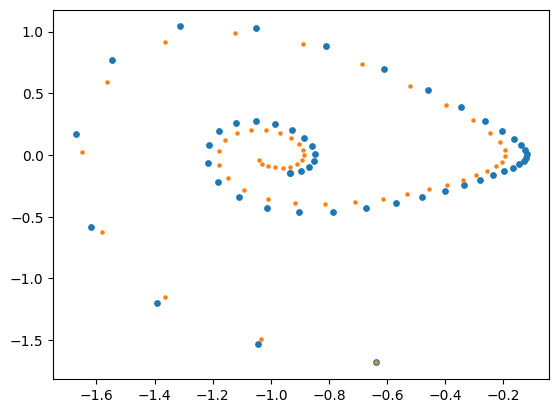

In [40]:
index = 0
plt.scatter(*dataset[index].T, s=15)
plt.scatter(*yhat[index].T, s=5)
